Импортируем всякое

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import roc_auc_score

Вдруг придётся преоткрыть

In [2]:
train = None
test = None
def reload_data():
    global train
    train = pd.read_csv("../data/raw/application_train.csv")
    global test
    test = pd.read_csv("../data/raw/application_test.csv")

Избавимся от y\n во флагах

In [3]:
def flag_to_int(df):
    for i in df:
        if "FLAG" in i:
            df[i] = np.where((df[i] == 'Y') | (df[i] == 'y') | (df[i] == 1), 1, 0)

In [294]:
reload_data()

In [295]:
flag_to_int(train)
flag_to_int(test)

In [5]:
target = "TARGET"

Достаём часть данных, чтобы ускорить работу

In [29]:
def eq_df(df):
    positive = df[df[target] == 1]
    negative = df[df[target] == 0]

    indexes1 = np.random.choice(len(positive), replace=False, size=20000)
    indexes2 = np.random.choice(len(negative), replace=False, size=20000)


    newdf = pd.concat([positive.iloc[indexes1], negative.iloc[indexes2]]).join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b').join(pd.read_csv("../data/raw/credit_card_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_ccb').join(pd.read_csv("../data/raw/previous_application.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pa').join(pd.read_csv("../data/raw/POS_CASH_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pcb')
    return newdf
lite = eq_df(train)
flag_to_int(lite)

Функция для тестиования и измерения orc auc

In [7]:
def comp_roc(df, features, target = "TARGET"):
    kf = KFold(n_splits=5, shuffle=True) #random_state=42)
    
    roc_list = []
    for i, (train_index, val_index) in enumerate(kf.split(df)):
        train_part = df.iloc[train_index, : ]
        train_x = train_part[features]
        train_y = train_part[target]
        
        val_part = df.iloc[val_index, :]
        test_x = val_part[features]
        test_y = val_part[target]
        
        model = LogisticRegression()
        
        model.fit(train_x, train_y)
        
        y_score = model.predict_proba(test_x)[:,1]

        fpr, tpr, _ = roc_curve(test_y, y_score)
        roc_auc = auc(fpr, tpr)

        print(f'Fold full {i}: roc_auc {roc_auc}')
        roc_list.append(roc_auc)

        
    print(f'roc average = {np.mean(roc_list)}, std = {np.std(roc_list)}')

Функция для тестирования и подсчёта msle

In [8]:

def comp_mse(df, features, target):
    kf = KFold(n_splits=5, shuffle=True) #random_state=42)
    
    msle_list = []
    mse_list = []
    for i, (train_index, val_index) in enumerate(kf.split(df)):    
        train_part = df.iloc[train_index, : ]
        val_part = df.iloc[val_index, :]
        model = SGDRegressor()
        model.fit(X=train_part[features].fillna(0), y = train_part[target])

        val_predication = model.predict(val_part[features].fillna(0)).clip(0, 100000000000)

        mse = mean_squared_error(val_predication, val_part[target])
        msle = mean_squared_log_error(val_predication, val_part[target])

        
        print(f'Fold full {i}: msle {msle}, mse {mse}')
        msle_list.append(msle)
        mse_list.append(mse)
        
    print(f'MSLE average = {np.mean(msle_list)}, std = {np.std(msle_list)}')
    

In [286]:
def predict_n_write_csv(features, path="predict1.csv"):
    target = "TARGET"
    
    model = LogisticRegression()
    model.fit(X=train[features].fillna(0), y = train[target])
    
    sample_submission = pd.read_csv("../data/raw/sample_submission.csv")
    sample_submission[target] = model.predict(test[features]) 
    sample_submission.to_csv(path, index= False)

Подготовка данных

In [18]:
def prepare_data(x1, x2=None):
    global train
    train = x1(train)
    if x2 != None:
        global test
        test = x2(test)

Подцепим флаги из осного сета

In [75]:
flags = ["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_CONT_MOBILE", "FLAG_EMAIL", "REG_REGION_NOT_WORK_REGION",
        # "DAYS_LAST_PHONE_CHANGE", 'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
         'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
            'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']

In [12]:
lite.AMT_CREDIT_SUM.fillna(0, inplace=True)

In [13]:
lite['have_credit'] = lite.AMT_CREDIT_SUM > lite.AMT_GOODS_PRICE

In [14]:
lite['have_credit'] = np.where(lite['have_credit'], 1, 0)


In [33]:
lite[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
133139,NaN,0.405187,0.372334,1
289474,NaN,0.481396,NaN,1
231829,NaN,0.266028,0.357293,1
137855,0.335982,0.110994,0.499272,1
290937,NaN,0.670619,0.427657,1
...,...,...,...,...
20494,0.625355,0.626707,0.553165,0
201100,NaN,0.490321,0.452534,0
274904,NaN,0.619296,0.631355,0
18886,0.304421,0.374914,NaN,0


Посмотрим как соотносятся EXT_SOURCE и target

In [32]:
comp_roc(lite[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3"])

Fold full 0: roc_auc 0.7535820188881415
Fold full 1: roc_auc 0.7451927706281072
Fold full 2: roc_auc 0.740897440057104
Fold full 3: roc_auc 0.7313612344798522
Fold full 4: roc_auc 0.743415780902137
roc average = 0.7428898489910684, std = 0.007166326750262817


In [19]:
predict_n_write_csv(['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3"], 'all_ext_souce.csv')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Увы есть пропуски, попробуем вычислсить.

In [79]:
comp_mse(lite[flags + ['EXT_SOURCE_1']].dropna(), flags, 'EXT_SOURCE_1')

Fold full 0: msle 0.02096066409388201, mse 0.04252253323409706
Fold full 1: msle 0.020866786047876975, mse 0.04267652518380931
Fold full 2: msle 0.020160541840401672, mse 0.04179879761141203
Fold full 3: msle 0.020979031810559746, mse 0.04313284735886135
Fold full 4: msle 0.02002594138254017, mse 0.04098056941109968
MSLE average = 0.020598593035052112, std = 0.0004165514061768037


### Кажется подбор $\pm$ успешен

In [180]:
def fillna_with_model(df, model, features, target):
    df[target] = np.where(df[target].isna(), model.predict(df[features]), df[target])

In [190]:
def fillna_EXT_SOURCE():
    model = SGDRegressor()
    target = 'EXT_SOURCE_1'
    part = train[flags + [target]].dropna()
    model.fit(X=part[flags], y=part[target])
    fillna_with_model(train, model, flags, target)
    fillna_with_model(test, model, flags, target)
    
    target = 'EXT_SOURCE_2'
    model = SGDRegressor()
    part =train[flags + [target]].dropna()
    model.fit(X=part[flags], y=part[target])
    fillna_with_model(train, model, flags, target) 
    fillna_with_model(test, model, flags, target)
    
    target = 'EXT_SOURCE_3'
    model = SGDRegressor()
    part = train[flags + [target]].dropna()
    model.fit(X=part[flags], y=part[target])
    fillna_with_model(train, model, flags, target)
    fillna_with_model(test, model, flags, target)

In [191]:
fillna_EXT_SOURCE()

In [183]:
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3"])

Fold full 0: roc_auc 0.7112418502082236
Fold full 1: roc_auc 0.7126698817554453
Fold full 2: roc_auc 0.7242850226707869
Fold full 3: roc_auc 0.7176454357725734
Fold full 4: roc_auc 0.7121437445511856
roc average = 0.715597186991643, std = 0.004881355364830903


## Private
0.49998
## Public
0.50072



In [192]:
predict_n_write_csv(['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3"], 'all_ext_souce.csv')

Попробуем ещё вариант с EXT_SOURC

In [193]:
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_1'])
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_2'])
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_3'])

Fold full 0: roc_auc 0.5451834710607748
Fold full 1: roc_auc 0.5481188149114582
Fold full 2: roc_auc 0.5438331562668351
Fold full 3: roc_auc 0.5429242603520854
Fold full 4: roc_auc 0.5521660285309793
roc average = 0.5464451462244266, std = 0.0033568024762432444
Fold full 0: roc_auc 0.6513946930737677
Fold full 1: roc_auc 0.6529431195483466
Fold full 2: roc_auc 0.6630523383834548
Fold full 3: roc_auc 0.6571530028870939
Fold full 4: roc_auc 0.6551613053587352
roc average = 0.6559408918502797, std = 0.004057196129037133
Fold full 0: roc_auc 0.6575766424444816
Fold full 1: roc_auc 0.6578959104863135
Fold full 2: roc_auc 0.6506894330641926
Fold full 3: roc_auc 0.6545250129009166
Fold full 4: roc_auc 0.6623883248254908
roc average = 0.656615064744279, std = 0.0038827092852727193


In [240]:
def predict_by_one(df, feature, df2):
    model = LogisticRegression()
    
    model.fit(X=df[feature], y=df[target])
    predictation = feature[0] + '_predict'
    df[predictation] = model.predict(df[feature])
    df2[predictation] = model.predict(df2[feature])

In [241]:
predict_by_one(train, ['EXT_SOURCE_1'],test)
predict_by_one(train, ['EXT_SOURCE_2'],test)
predict_by_one(train, ['EXT_SOURCE_3'],test)

In [233]:
comp_roc(train[['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict", target]].dropna(), ['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict"])

Fold full 0: roc_auc 0.5
Fold full 1: roc_auc 0.5
Fold full 2: roc_auc 0.5
Fold full 3: roc_auc 0.5
Fold full 4: roc_auc 0.5
roc average = 0.5, std = 0.0


### Private
0.50000

### Public
0.50000

Похоже на ошибку, но я пока не понял

In [274]:
predict_n_write_csv(['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict"], 'all_ext_souce_plus.csv')

Раз мы можем получить из флагов EXT_SOURCE, значит из них можжем получить и финальный результат:

In [243]:
comp_roc(train[flags + [target]].dropna(), flags)

Fold full 0: roc_auc 0.5678522474258474
Fold full 1: roc_auc 0.5689888681945905
Fold full 2: roc_auc 0.5724018391184615
Fold full 3: roc_auc 0.5711665895741147
Fold full 4: roc_auc 0.572526733401355
roc average = 0.5705872555428738, std = 0.0018668169353976726


Ерунда какая-то:
### Private
0.50000

### Public
0.50000

In [244]:
predict_n_write_csv(flags, 'just_fkags.csv')

Попробую добваить новый флаг

In [247]:
lite["have_big_credit"] = lite['AMT_CREDIT_SUM'] > lite['AMT_GOODS_PRICE']
lite["have_big_credit"] = np.where(lite["have_big_credit"], 1, 0)

In [253]:
comp_roc(lite[flags + [target, 'have_big_credit']].dropna(), flags)

Fold full 0: roc_auc 0.5716186614893572
Fold full 1: roc_auc 0.5694195694195694
Fold full 2: roc_auc 0.5752460447863479
Fold full 3: roc_auc 0.5717554889727208
Fold full 4: roc_auc 0.5719491998206022
roc average = 0.5719977928977195, std = 0.001865646790755559


### Private
0.50000

### Public
0.50000

In [264]:
# test=test.join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b')
train=train.join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b')


In [265]:
train["have_big_credit"] = train['AMT_CREDIT_SUM'] > train['AMT_GOODS_PRICE']
train["have_big_credit"] = np.where(train["have_big_credit"], 1, 0)

test["have_big_credit"] = test['AMT_CREDIT_SUM'] > test['AMT_GOODS_PRICE']
test["have_big_credit"] = np.where(test["have_big_credit"], 1, 0)

In [262]:
flags.append('have_big_credit')

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_OWN_REALTY',
 'FLAG_OWN_CAR',
 'have_big_credit']

In [263]:
test[flags]

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_OWN_REALTY,FLAG_OWN_CAR,have_big_credit
0,1,1,1,1,0,0,0,0,1,0,1
1,1,1,1,0,0,0,0,0,1,0,1
2,1,1,1,0,0,0,0,0,1,1,0
3,1,1,1,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48739,1,1,1,0,0,0,0,0,1,0,1
48740,1,1,1,0,0,0,0,1,0,0,1
48741,1,1,1,0,0,0,0,0,1,1,0
48742,1,1,1,0,1,1,0,1,0,0,0


In [266]:
predict_n_write_csv(flags, 'just_flags_plus.csv')

Выходной scor повторяется и я попробую что-то испортить, чтобы понять, не сломалась ли кегля

In [268]:
def count_docs(df):
    df['DOCUMENT_FLAGS_COUNT'] = df['FLAG_DOCUMENT_2'] + df['FLAG_DOCUMENT_3'] + df['FLAG_DOCUMENT_4'] + df['FLAG_DOCUMENT_5'] + df['FLAG_DOCUMENT_6'] + df['FLAG_DOCUMENT_7'] + df['FLAG_DOCUMENT_8'] + df['FLAG_DOCUMENT_9'] + df['FLAG_DOCUMENT_10'] + df['FLAG_DOCUMENT_11'] + df['FLAG_DOCUMENT_12'] + df['FLAG_DOCUMENT_13'] + df['FLAG_DOCUMENT_14'] + df['FLAG_DOCUMENT_15'] + df['FLAG_DOCUMENT_16'] + df['FLAG_DOCUMENT_17'] + df['FLAG_DOCUMENT_18'] + df['FLAG_DOCUMENT_19'] + df['FLAG_DOCUMENT_20'] + df['FLAG_DOCUMENT_21']

In [272]:
count_docs(train)
count_docs(test)

In [271]:
comp_roc(train[flags + ["DOCUMENT_FLAGS_COUNT", target]], flags + ['DOCUMENT_FLAGS_COUNT'])

Fold full 0: roc_auc 0.5712414854940149
Fold full 1: roc_auc 0.573990204799666
Fold full 2: roc_auc 0.5781153541316969
Fold full 3: roc_auc 0.575047968897403
Fold full 4: roc_auc 0.5740440558566741
roc average = 0.5744878138358909, std = 0.002211606017850045


### Private
0.50000

### Public
0.50000

In [280]:
predict_n_write_csv(flags + ['DOCUMENT_FLAGS_COUNT'], 'flags_docs.csv')

In [278]:
comp_roc(train[flags + ["DOCUMENT_FLAGS_COUNT", 'AMT_INCOME_TOTAL', target]].fillna(0), flags + ['DOCUMENT_FLAGS_COUNT', 'AMT_INCOME_TOTAL'])

Fold full 0: roc_auc 0.5186219008038513
Fold full 1: roc_auc 0.5154944187650218
Fold full 2: roc_auc 0.5157869517304228
Fold full 3: roc_auc 0.5214029429053113
Fold full 4: roc_auc 0.5164069581586329
roc average = 0.517542634472648, std = 0.0022196471420245886


In [281]:
predict_n_write_csv(flags + ['DOCUMENT_FLAGS_COUNT', 'AMT_INCOME_TOTAL'], 'flags_docs_money.csv')

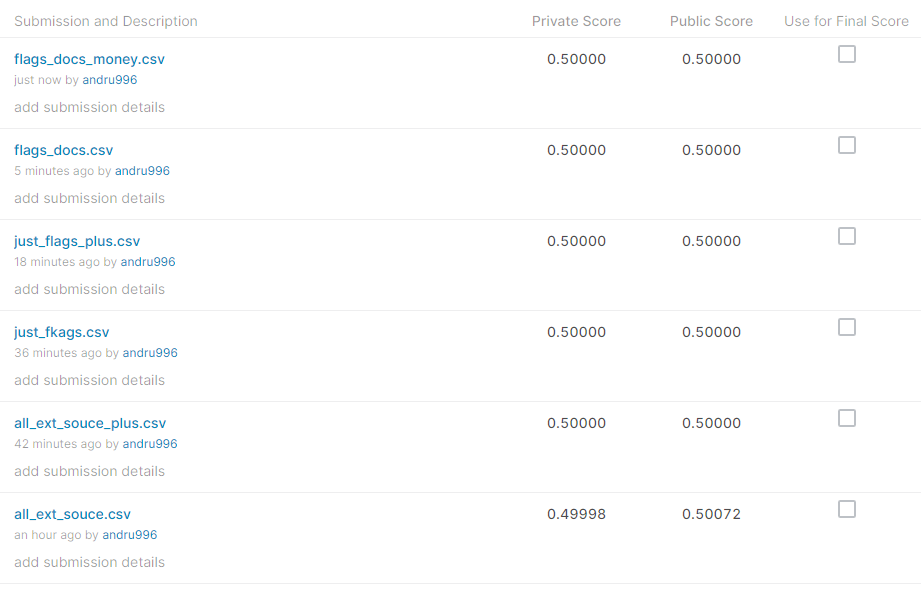

In [298]:
flags = ["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_CONT_MOBILE", "FLAG_EMAIL", "REG_REGION_NOT_WORK_REGION",
         "DAYS_LAST_PHONE_CHANGE", 'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
         'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
            'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']
comp_roc(train[flags + [target]].fillna(0), flags)

Fold full 0: roc_auc 0.5890975625395503
Fold full 1: roc_auc 0.6009742634073062
Fold full 2: roc_auc 0.5914323094627216


/home/andru/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold full 3: roc_auc 0.5885129905308993
Fold full 4: roc_auc 0.5920979341274757
roc average = 0.5924230120135906, std = 0.004484594736971548


In [296]:
comp_roc(lite[flags + [target]].fillna(0), flags)

Fold full 0: roc_auc 0.5928844063386283
Fold full 1: roc_auc 0.5891603268130106
Fold full 2: roc_auc 0.5996874135676012
Fold full 3: roc_auc 0.5809530809944272
Fold full 4: roc_auc 0.5917371772334857
roc average = 0.5908844809894307, std = 0.006063395546187418


In [287]:
predict_n_write_csv(flags, 'trash.csv')

In [297]:
comp_roc(train[[target, "SK_ID_CURR"]].fillna(0), ["SK_ID_CURR"])

Fold full 0: roc_auc 0.5061332045875804
Fold full 1: roc_auc 0.502174846045988
Fold full 2: roc_auc 0.49614848406741624
Fold full 3: roc_auc 0.5010339972156963
Fold full 4: roc_auc 0.5058621012544408
roc average = 0.5022705266342243, std = 0.0036561524637680606
